In [1]:
from pandas import read_excel
from pandas import DataFrame
from pandas import merge
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# 모델을 구성하기위한 객체
from tensorflow.keras.models import Sequential
# 모델에 학습층을 쌓기 위한 클래스
from tensorflow.keras.layers import Dense
# 데이터를 훈련용과 테스트용으로 나누는 기능
from sklearn.model_selection import train_test_split

# 학습에 대한 콜백함수 처리용 패키지 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# 표준화 처리 패키지
from sklearn.preprocessing import StandardScaler
# (신규) 분류결과 평가 지표 관련 패키지
from sklearn.metrics import classification_report, confusion_matrix

# 회귀분석을 수행하는 통계 패키지 (머신러닝과는 연관 없음)
from statsmodels.formula.api import logit

In [2]:
np.random.seed(777)

In [3]:
df = read_excel('http://itpaper.co.kr/data/flight_delays.xlsx', engine='openpyxl')
df

,FL_NUM,TAIL_NUM,FL_DATE,DAY_WEEK,CRS_DEP_TIME,DEP_TIME,ORIGIN,DEST,CARRIER,DISTANCE,WEATHER,FLIGHT_STATUS
0,5935,N940CA,2004/01/01,4,1455,1455,BWI,JFK,OH,184,0,ontime
1,6155,N405FJ,2004/01/01,4,1640,1640,DCA,JFK,DH,213,0,ontime
2,7208,N695BR,2004/01/01,4,1245,1245,IAD,LGA,DH,229,0,ontime
3,7215,N662BR,2004/01/01,4,1715,1709,IAD,LGA,DH,229,0,ontime
4,7792,N698BR,2004/01/01,4,1039,1035,IAD,LGA,DH,229,0,ontime
...,...,...,...,...,...,...,...,...,...,...,...,...
2196,2761,N15555,2004/1/31,6,645,644,DCA,EWR,RU,199,0,ontime
2197,2497,N16976,2004/1/31,6,1700,1653,IAD,EWR,RU,213,0,ontime
2198,2361,N14902,2004/1/31,6,1600,1558,DCA,EWR,RU,199,0,ontime
2199,2216,N16961,2004/1/31,6,1359,1403,DCA,EWR,RU,199,0,ontime


In [4]:
df.isna().sum()

FL_NUM           0
TAIL_NUM         0
FL_DATE          0
DAY_WEEK         0
CRS_DEP_TIME     0
DEP_TIME         0
ORIGIN           0
DEST             0
CARRIER          0
DISTANCE         0
WEATHER          0
FLIGHT_STATUS    0
dtype: int64

In [5]:
df = df.astype({'DEST': 'category', 'FLIGHT_STATUS': 'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   FL_NUM         2201 non-null   int64   
 1   TAIL_NUM       2201 non-null   object  
 2   FL_DATE        2201 non-null   object  
 3   DAY_WEEK       2201 non-null   int64   
 4   CRS_DEP_TIME   2201 non-null   int64   
 5   DEP_TIME       2201 non-null   int64   
 6   ORIGIN         2201 non-null   object  
 7   DEST           2201 non-null   category
 8   CARRIER        2201 non-null   object  
 9   DISTANCE       2201 non-null   int64   
 10  WEATHER        2201 non-null   int64   
 11  FLIGHT_STATUS  2201 non-null   category
dtypes: category(2), int64(6), object(4)
memory usage: 176.6+ KB


In [6]:
df['DEST'].value_counts()

LGA    1150
EWR     665
JFK     386
Name: DEST, dtype: int64

In [7]:
df['DEST'] = df['DEST'].cat.rename_categories({'LGA':1, 'EWR':2, 'JFK':3}).astype('int')
df['DEST'].value_counts()

1    1150
2     665
3     386
Name: DEST, dtype: int64

In [8]:
df['FLIGHT_STATUS'].value_counts()

ontime     1773
delayed     428
Name: FLIGHT_STATUS, dtype: int64

In [11]:
df['FLIGHT_STATUS'] = df['FLIGHT_STATUS'].cat.rename_categories({'ontime':1, 'delayed':0}).astype('int')
df['FLIGHT_STATUS'].value_counts()

1    1773
0     428
Name: FLIGHT_STATUS, dtype: int64

In [12]:
df.describe()

,FL_NUM,DAY_WEEK,CRS_DEP_TIME,DEP_TIME,DEST,DISTANCE,WEATHER,FLIGHT_STATUS
count,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000
mean,3815.086324,3.905498,1371.938664,1369.298955,1.652885,211.871422,0.014539,0.805543
std,2409.750224,1.903149,432.697149,442.462754,0.760025,13.316815,0.119725,0.395872
min,746.000000,1.000000,600.000000,10.000000,1.000000,169.000000,0.000000,0.000000
25%,2156.000000,2.000000,1000.000000,1004.000000,1.000000,213.000000,0.000000,1.000000
50%,2385.000000,4.000000,1455.000000,1450.000000,1.000000,214.000000,0.000000,1.000000
75%,6155.000000,5.000000,1710.000000,1709.000000,2.000000,214.000000,0.000000,1.000000
max,7924.000000,7.000000,2130.000000,2330.000000,3.000000,229.000000,1.000000,1.000000


In [13]:
x_train_set = df.filter(['DAY_WEEK', 'CRS_DEP_TIME', 'DEP_TIME', 'DEST', 'WEATHER', 'DISTANCE'])
y_train_set = df.filter(['FLIGHT_STATUS'])
print("훈련데이터 크기:", x_train_set.shape, "/ 레이블 크기:", y_train_set.shape)
x_train_set

훈련데이터 크기: (2201, 6) / 레이블 크기: (2201, 1)


,DAY_WEEK,CRS_DEP_TIME,DEP_TIME,DEST,WEATHER,DISTANCE
0,4,1455,1455,3,0,184
1,4,1640,1640,3,0,213
2,4,1245,1245,1,0,229
3,4,1715,1709,1,0,229
4,4,1039,1035,1,0,229
...,...,...,...,...,...,...
2196,6,645,644,2,0,199
2197,6,1700,1653,2,0,213
2198,6,1600,1558,2,0,199
2199,6,1359,1403,2,0,199


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_train_set, y_train_set, test_size=0.33, random_state=777)
print("훈련용 데이터셋 크기: %d, 검증용 데이터셋 크기: %d" % (len(x_train), len(x_test)))

훈련용 데이터셋 크기: 1474, 검증용 데이터셋 크기: 727


In [15]:
scaler = StandardScaler()
std_x_train = DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
std_x_test = DataFrame(scaler.transform(x_test), columns=x_test.columns)
std_x_train.head()
std_x_test.head()

,DAY_WEEK,CRS_DEP_TIME,DEP_TIME,DEST,WEATHER,DISTANCE
0,0.564655,-1.248370,-1.227236,1.795470,-0.12022,1.223134
1,-1.516099,-0.186700,-0.271198,-0.840509,-0.12022,0.154794
2,0.044467,0.736491,0.619605,-0.840509,-0.12022,0.154794
3,1.084844,-0.186700,-0.273447,0.477481,-0.12022,-0.989855
4,0.564655,0.171036,0.183202,1.795470,-0.12022,1.223134


In [16]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(len(std_x_test.columns), )))
model.add(Dense(1, activation='sigmoid', input_shape=(len(std_x_test.columns), )))
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                112       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [17]:
result = model.fit(std_x_train, y_train, epochs = 500, validation_data = (std_x_test, y_test), callbacks = [
    #ModelCheckpoint(filepath = 'check_point.h5', monitor = 'val_loss', verbose=1, save_best_only = True),
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

Epoch 1/500
47/47 [==============================] - 1s 4ms/step - loss: 0.6084 - acc: 0.7259 - val_loss: 0.5718 - val_acc: 0.7717
Epoch 2/500
47/47 [==============================] - 0s 1ms/step - loss: 0.5344 - acc: 0.8005 - val_loss: 0.5336 - val_acc: 0.7937
Epoch 3/500
47/47 [==============================] - 0s 1ms/step - loss: 0.5010 - acc: 0.8114 - val_loss: 0.5174 - val_acc: 0.7950
Epoch 4/500
47/47 [==============================] - 0s 1ms/step - loss: 0.4851 - acc: 0.8107 - val_loss: 0.5080 - val_acc: 0.7964
Epoch 5/500
47/47 [==============================] - 0s 1ms/step - loss: 0.4755 - acc: 0.8175 - val_loss: 0.5018 - val_acc: 0.8102
Epoch 6/500
47/47 [==============================] - 0s 1ms/step - loss: 0.4692 - acc: 0.8250 - val_loss: 0.4974 - val_acc: 0.8102
Epoch 7/500
47/47 [==============================] - 0s 1ms/step - loss: 0.4646 - acc: 0.8250 - val_loss: 0.4951 - val_acc: 0.8102
Epoch 8/500
47/47 [==============================] - 0s 1ms/step - loss: 0.4612 - a

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,0.608414,0.725916,0.571782,0.771664,0.0010
2,0.534361,0.800543,0.533585,0.793673,0.0010
3,0.501036,0.811398,0.517371,0.795048,0.0010
4,0.485085,0.810719,0.508004,0.796424,0.0010
5,0.475488,0.817503,0.501763,0.810179,0.0010
...,...,...,...,...,...
206,0.357996,0.872456,0.375325,0.843191,0.0001
207,0.357951,0.871777,0.375289,0.843191,0.0001
208,0.357934,0.870421,0.375427,0.843191,0.0001


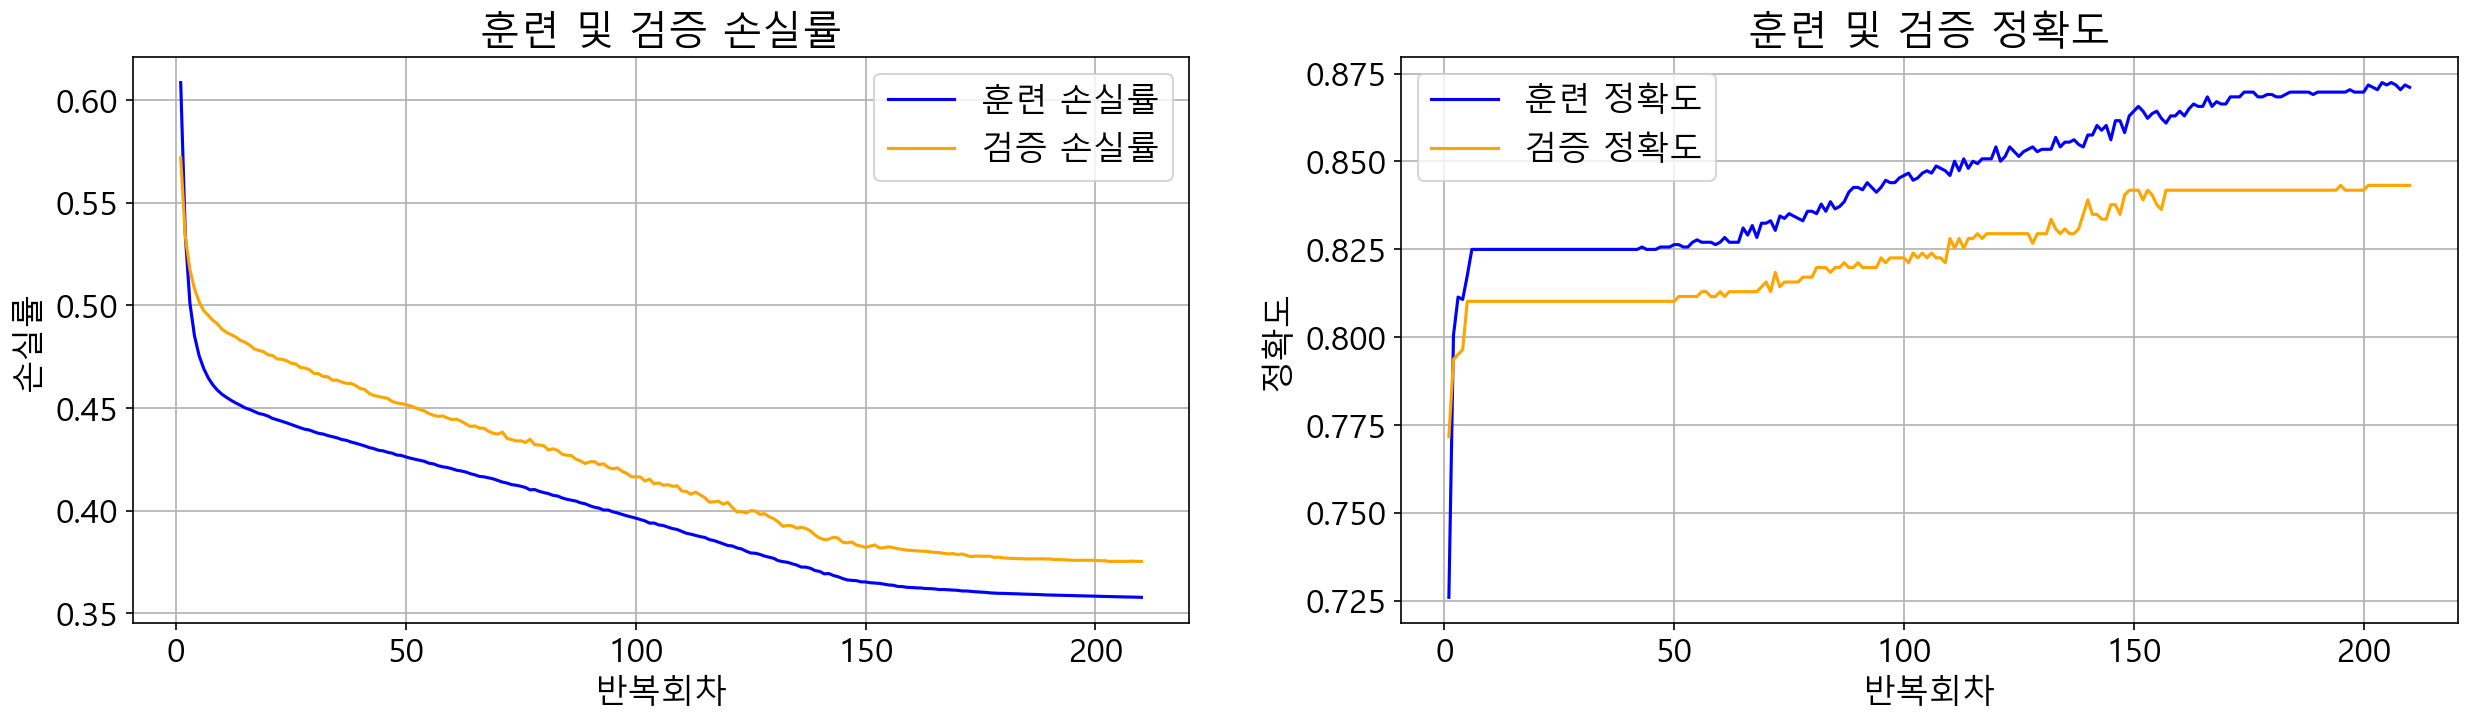

In [18]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sns.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 정확도 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='acc', data=result_df, color = 'blue', label = '훈련 정확도', ax=ax2)
sns.lineplot(x=result_df.index, y='val_acc', data=result_df, color = 'orange', label = '검증 정확도', ax=ax2)
ax2.set_title('훈련 및 검증 정확도')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [19]:
results = model.predict(std_x_test)
data_count, case_count = results.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
print(results)

727개의 검증 데이터가 1개의 경우의 수를 갖는다.
[[8.47930670e-01]
 [9.36490655e-01]
 [9.18345630e-01]
 [9.26362991e-01]
 [8.96378040e-01]
 [8.79568458e-01]
 [7.90619016e-01]
 [9.21211064e-01]
 [9.35856879e-01]
 [9.23119068e-01]
 [7.93442607e-01]
 [9.12737131e-01]
 [6.46519065e-01]
 [8.78910780e-01]
 [9.10500705e-01]
 [7.68569052e-01]
 [8.97657573e-01]
 [8.87085676e-01]
 [7.60790408e-01]
 [9.38326955e-01]
 [8.19231153e-01]
 [7.72681594e-01]
 [8.81007910e-01]
 [7.83613801e-01]
 [9.04781580e-01]
 [8.54352951e-01]
 [6.77775621e-01]
 [7.89807558e-01]
 [9.10518706e-01]
 [8.71699810e-01]
 [9.02220130e-01]
 [8.27607214e-01]
 [7.45575130e-01]
 [8.74418616e-01]
 [7.85018146e-01]
 [7.48662472e-01]
 [8.98451626e-01]
 [8.85775566e-01]
 [8.73462796e-01]
 [9.06305671e-01]
 [8.96016717e-01]
 [7.46656239e-01]
 [7.74232626e-01]
 [8.70368958e-01]
 [5.66174924e-01]
 [8.61066937e-01]
 [8.98484707e-01]
 [7.75085688e-01]
 [8.57515693e-01]
 [8.42337549e-01]
 [6.85115218e-01]
 [7.09044635e-01]
 [7.79740691e-01]
 [8.93209577e-01

In [20]:
f_results = results.flatten()
f_results

array([8.47930670e-01, 9.36490655e-01, 9.18345630e-01, 9.26362991e-01,
       8.96378040e-01, 8.79568458e-01, 7.90619016e-01, 9.21211064e-01,
       9.35856879e-01, 9.23119068e-01, 7.93442607e-01, 9.12737131e-01,
       6.46519065e-01, 8.78910780e-01, 9.10500705e-01, 7.68569052e-01,
       8.97657573e-01, 8.87085676e-01, 7.60790408e-01, 9.38326955e-01,
       8.19231153e-01, 7.72681594e-01, 8.81007910e-01, 7.83613801e-01,
       9.04781580e-01, 8.54352951e-01, 6.77775621e-01, 7.89807558e-01,
       9.10518706e-01, 8.71699810e-01, 9.02220130e-01, 8.27607214e-01,
       7.45575130e-01, 8.74418616e-01, 7.85018146e-01, 7.48662472e-01,
       8.98451626e-01, 8.85775566e-01, 8.73462796e-01, 9.06305671e-01,
       8.96016717e-01, 7.46656239e-01, 7.74232626e-01, 8.70368958e-01,
       5.66174924e-01, 8.61066937e-01, 8.98484707e-01, 7.75085688e-01,
       8.57515693e-01, 8.42337549e-01, 6.85115218e-01, 7.09044635e-01,
       7.79740691e-01, 8.93209577e-01, 8.84812355e-01, 9.06166553e-01,
      

In [21]:
kdf = DataFrame({
    '결과값': y_test['FLIGHT_STATUS'],
    '정상도착확률(%)': np.round(f_results * 100, 1),
    '예측치' : np.round(f_results)
})

kdf

,결과값,정상도착확률(%),예측치
2075,1,84.800003,1.0
809,1,93.599998,1.0
1558,1,91.800003,1.0
2188,1,92.599998,1.0
1611,1,89.599998,1.0
...,...,...,...
1033,1,83.300003,1.0
1823,1,79.199997,1.0
932,1,77.400002,1.0
153,1,75.900002,1.0


In [22]:
# 예측 데이터(ca_y_test)를 x축으로, 결과 데이터(results)를 y축으로 놓는 오차행렬(confusion_matrix) 생성하기 
cm = confusion_matrix(kdf['결과값'], kdf['예측치'])
cmdf1 = DataFrame(cm, columns=['예측값(P)', '예측값(N)'], index=['실제값(P)', '실제값(N)'])
cmdf1

,예측값(P),예측값(N)
실제값(P),35,114
실제값(N),0,578


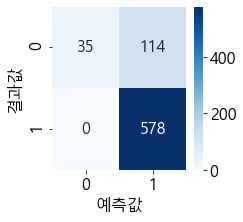

In [23]:
# --> 5를 분류할 때 가장 많이 혼란스러워 한다.
# --> 오차행렬은 모델의 강점과 약점을 파악하기에 유용하다.
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams["figure.figsize"] = (3, 3)

# 오차 행렬을 히트맵 그래프로 표현
# -> annot : 그래프의 각 칸에 수치값 출력
# -> fmt : 수치값 출력 format (여기서는 10진수)
# -> cmap : 색상맵 (https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html)
sns.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')
plt.xlabel('예측값')
plt.ylabel('결과값')
plt.show()

In [24]:
report = classification_report(kdf['결과값'], kdf['예측치'])
print(report)

              precision    recall  f1-score   support

           0       1.00      0.23      0.38       149
           1       0.84      1.00      0.91       578

    accuracy                           0.84       727
   macro avg       0.92      0.62      0.65       727
weighted avg       0.87      0.84      0.80       727



In [26]:
from pandas import merge
train_df = merge(x_train, y_train, left_index=True, right_index=True)
train_df

,DAY_WEEK,CRS_DEP_TIME,DEP_TIME,DEST,WEATHER,DISTANCE,FLIGHT_STATUS
2102,5,900,850,1,0,214,1
507,4,800,759,1,0,214,1
857,2,1455,1453,3,0,213,1
974,3,900,856,1,0,214,1
1057,4,1700,1701,1,0,214,1
...,...,...,...,...,...,...,...
985,3,2000,1959,1,0,214,0
116,6,840,855,3,0,228,1
1693,6,1800,1751,3,0,228,1
2119,5,1500,1459,1,0,214,1


In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1474 entries, 2102 to 2151
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   DAY_WEEK       1474 non-null   int64
 1   CRS_DEP_TIME   1474 non-null   int64
 2   DEP_TIME       1474 non-null   int64
 3   DEST           1474 non-null   int32
 4   WEATHER        1474 non-null   int64
 5   DISTANCE       1474 non-null   int64
 6   FLIGHT_STATUS  1474 non-null   int32
dtypes: int32(2), int64(5)
memory usage: 112.9 KB


In [28]:
model = logit('FLIGHT_STATUS ~ DAY_WEEK + CRS_DEP_TIME + DEP_TIME + DEST + WEATHER + DISTANCE', data=train_df)
fit = model.fit()
print(fit.summary())

         Current function value: 0.377038
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:          FLIGHT_STATUS   No. Observations:                 1474
Model:                          Logit   Df Residuals:                     1467
Method:                           MLE   Df Model:                            6
Date:                Fri, 09 Jul 2021   Pseudo R-squ.:                  0.2229
Time:                        14:34:15   Log-Likelihood:                -555.75
converged:                      False   LL-Null:                       -715.15
Covariance Type:            nonrobust   LLR p-value:                 7.639e-66
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7688      1.188      0.647      0.518      -1.561       3.098
DAY_WEEK         0.0342      0.040      0.853      0.394   

c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
from pandas import merge
test_df = merge(x_test, y_test, left_index=True, right_index=True)
test_df
pred2 = fit.predict(test_df)
pred2

2075    0.903479
809     0.930475
1558    0.931946
2188    0.936076
1611    0.847813
          ...   
1033    0.806178
1823    0.803462
932     0.817510
153     0.788869
1484    0.929494
Length: 727, dtype: float64

In [30]:
kdf['통계치'] = np.round(pred2.values)
kdf

,결과값,정상도착확률(%),예측치,통계치
2075,1,84.800003,1.0,1.0
809,1,93.599998,1.0,1.0
1558,1,91.800003,1.0,1.0
2188,1,92.599998,1.0,1.0
1611,1,89.599998,1.0,1.0
...,...,...,...,...
1033,1,83.300003,1.0,1.0
1823,1,79.199997,1.0,1.0
932,1,77.400002,1.0,1.0
153,1,75.900002,1.0,1.0


In [31]:
# 예측 데이터(ca_y_test)를 x축으로, 결과 데이터(results)를 y축으로 놓는 오차행렬(confusion_matrix) 생성하기 
cm = confusion_matrix(kdf['결과값'], kdf['통계치'])
cmdf2 = DataFrame(cm, columns=['예측값(P)', '예측값(N)'], index=['실제값(P)', '실제값(N)'])
cmdf2

,예측값(P),예측값(N)
실제값(P),56,93
실제값(N),0,578


In [32]:
x = (cmdf1['예측값(P)']['실제값(P)']+cmdf1['예측값(N)']['실제값(N)']) / len(y_test)
y = (cmdf2['예측값(P)']['실제값(P)']+cmdf2['예측값(N)']['실제값(N)']) / len(y_test)
print('머신러닝 분류 정확도 : %0.2f%%, 통계 분류 정확도 : %0.2f%%' % (x, y))

머신러닝 분류 정확도 : 0.84%, 통계 분류 정확도 : 0.87%
